In [1]:
%autosave 0

Autosave disabled


In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar as colorbar
from sphere6d import sphere6d
from plummer_sampler import plummer_model

In [2]:
plummer_mod = plummer_model(np.radians(4.5/60.)*5000., 10000)

In [3]:
cluster_ra = (13. + 26. / 60. + 47.28 / 3600.) * 15.
cluster_dec = -1 * (47. + 28. / 60. + 46.1 / 3600.)
cluster_pmra = 10  # in mas
cluster_pmdec = -10.  # in mas
cluster_rv = 100.
cluster_dist = 5000
cluster_tidal_rad_arcmin = 45.
cluster_tidal_rad = np.radians(cluster_tidal_rad_arcmin / 60.) * cluster_dist
cluster_hl_rad = np.radians(4.5 / 60.) * cluster_dist

pmra_sys = 10.
pmdec_sys = -10.
rv_sys = 100
vmax = 13.
ramp = 8.
inclination = np.radians(61.)
omega = np.radians(35.)
vsigma = 10.

In [4]:
fixed_param = ['rot_curve', 'density_dist',
               'shape_func', 'rmax', 'ra', 'dec', 'dist']
fit_param = ['vel_disp', 'vmax', 'ramp', 'pmra_sys', 'pmdec_sys', 'rv_sys',
             'inclination', 'omega']
fixed_values = ['mackey2013', ['plummer_precomp', plummer_mod.rad, plummer_mod.phi, plummer_mod.theta], 
                'ellipsoidal', cluster_tidal_rad, cluster_ra, cluster_dec, cluster_dist]
# fixed_values = ['mackey2013', ['linear'], 'ellipsoidal', ocen_tidal_rad,
#                 ocen_ra, ocen_dec, ocen_dist]
fit_values = [vsigma, vmax, ramp, pmra_sys,
              pmdec_sys, rv_sys, inclination, omega]

In [5]:
dict_keys = fixed_param + fit_param
dict_values = fixed_values + fit_values

init_dict = {dict_keys[i]: dict_values[i] for i in range(len(dict_keys))}

In [6]:
cluster = sphere6d(init_dict)

In [24]:
def plot_model(cluster,model,motion):

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    
    if motion == 'rv':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_rvs-model.obs_rv_sys, bins=75)
        vmin = -15.
        vmax = 15.
        systemic = model.obs_rv_sys
        indiv = cluster.obs_rvs
        label = 'RV'

    if motion == 'pmra':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_pmras-model.obs_pmra_sys, bins=75)
        vmin = -1.
        vmax = 1.
        systemic = model.obs_pmra_sys
        indiv = cluster.obs_pmras
        label = 'PM RA'



    if motion == 'pmdec':
        
        H2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                            weights = model.obs_pmdecs-model.obs_pmdec_sys, bins=75)
        vmin = -1.
        vmax = 1.
        systemic = model.obs_pmdec_sys
        indiv = cluster.obs_pmdecs
        label = 'PM Dec'


    Hcounts2, xedges, yedges = np.histogram2d(model.obs_ras,model.obs_decs,
                                              bins=[xedges,yedges])

    extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]

    H2 = H2/Hcounts2
    masked_H2=np.ma.masked_where(Hcounts2 < 1, H2)

    cset1 = ax.imshow(masked_H2.transpose((1,0)),extent=extent, cmap = plt.get_cmap('RdBu'),
                      origin='lower',interpolation='nearest', zorder=2, aspect='auto', vmin=vmin, vmax=vmax)

    cset2 = ax.scatter(cluster.obs_ras, cluster.obs_decs, c=indiv-systemic, s = 10, 
                           zorder = 3, cmap = plt.get_cmap('RdBu'), vmin=vmin, vmax=vmax)



    ax.tick_params(axis='both',direction='in',labelsize=15)

    ax.set_xlim([200.5,203])
    ax.set_ylim([-48.2,-46.8])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(cset1,cax=cax)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label(label,fontsize=18)
    ax.set_xlabel('RA',fontsize=18)
    ax.set_ylabel('Dec',fontsize=18)

    ax.invert_xaxis()

    plt.show()
    print(model.obs_pmra_sys,model.obs_pmdec_sys,model.obs_rv_sys,np.degrees(model.inclination),
         np.degrees(model.omega),model.vel_disp,model.vmax,model.ramp)

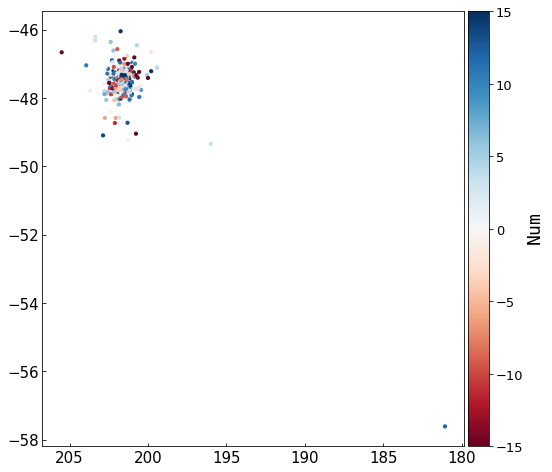

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

vmin = -15.
vmax = 15.

cset1 = ax.scatter(cluster.obs_ras, cluster.obs_decs, 
                   c=cluster.obs_rvs-cluster.obs_rv_sys+np.random.randn(
                       len(cluster.obs_rvs))*vsigma, s = 10, 
                   zorder = 3, cmap = plt.get_cmap('RdBu'), vmin=vmin, vmax=vmax)



ax.tick_params(axis='both',direction='in',labelsize=15)

# ax.set_xlim([200.5,203])
# ax.set_ylim([-48.2,-46.8])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(cset1,cax=cax)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'$\mathtt{Num}$',fontsize=18)

ax.invert_xaxis()

plt.show()

In [9]:
cluster.obs_rvs+=np.random.randn(len(cluster.obs_rvs))*vsigma
cluster.obs_pmras+=np.random.randn(len(cluster.obs_pmras))*vsigma/(4.74*cluster_dist)
cluster.obs_pmdecs+=np.random.randn(len(cluster.obs_pmdecs))*vsigma/(4.74*cluster_dist)

In [10]:
data_keys = ['data_ra','data_dec','data_rv','data_pmra','data_pmdec']
data_values = [cluster.obs_ras,cluster.obs_decs,cluster.obs_rvs,cluster.obs_pmras,cluster.obs_pmdecs]
data = {data_keys[i]: data_values[i] for i in range(len(data_keys))}

In [22]:
cluster_ra = (13. + 26. / 60. + 47.28 / 3600.) * 15.
cluster_dec = -1 * (47. + 28. / 60. + 46.1 / 3600.)
cluster_pmra = 10  # in mas
cluster_pmdec = -10.  # in mas
cluster_rv = 100.
cluster_dist = 5000
cluster_tidal_rad_arcmin = 45.
cluster_tidal_rad = np.radians(cluster_tidal_rad_arcmin / 60.) * cluster_dist
cluster_hl_rad = np.radians(4.5 / 60.) * cluster_dist

pmra_sys = 0.
pmdec_sys = 0.
rv_sys = 100
vmax = 10.
ramp = 10.
inclination = np.radians(0.)
omega = np.radians(0.)
vsigma = 10.

fixed_param = ['rot_curve', 'density_dist',
               'shape_func', 'rmax', 'ra', 'dec', 'dist']
fit_param = ['vel_disp', 'vmax', 'ramp', 'pmra_sys', 'pmdec_sys', 'rv_sys',
             'inclination', 'omega']
fixed_values = ['mackey2013', ['linear'], 'ellipsoidal', cluster_tidal_rad,
                cluster_ra, cluster_dec, cluster_dist]
fit_values = [vsigma, vmax, ramp, pmra_sys,
              pmdec_sys, rv_sys, inclination, omega]

dict_keys = fixed_param + fit_param
dict_values = fixed_values + fit_values

init_dict = {dict_keys[i]: dict_values[i] for i in range(len(dict_keys))}

cluster_model = sphere6d(init_dict)

cluster_model.fit(**data, xtol=0.1, ftol=0.01)

/Users/chayes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


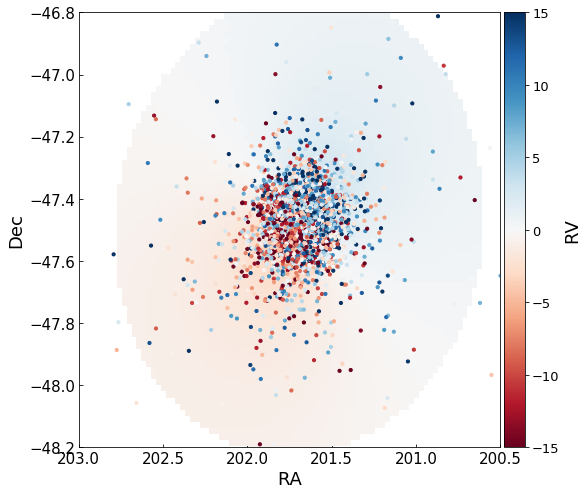

10.002696709969186 -10.003309434803159 100.07346182285943 108.12769356303448 -129.82358858226783 10.0 15.07554055845119 5.842955058688864


In [25]:
plot_model(cluster,cluster_model,'rv')

In [32]:
cluster_inputs = [cluster.obs_pmra_sys,cluster.obs_pmdec_sys,cluster.obs_rv_sys,np.degrees(cluster.inclination), 
                  np.degrees(cluster.omega),cluster.vmax,cluster.ramp]

model_outputs = [cluster_model.obs_pmra_sys,cluster_model.obs_pmdec_sys,cluster_model.obs_rv_sys,
                 np.degrees(cluster_model.inclination), np.degrees(cluster_model.omega),
                 cluster_model.vmax,cluster_model.ramp]

labels = ['Systemic PM RA', 'Systemic PM Dec', 'Systemic RV', 'Inclination', 'Omega', 'Vmax', 'R amp']

for label, truth, fit in zip(labels,cluster_inputs,model_outputs):
    print('{}: Input = {:4.1f} / Fit = {:4.1f}'.format(label,truth,fit))

Systemic PM RA: Input = 10.0 / Fit = 10.0
Systemic PM Dec: Input = -10.0 / Fit = -10.0
Systemic RV: Input = 100.0 / Fit = 100.1
Inclination: Input = 61.0 / Fit = 108.1
Omega: Input = 35.0 / Fit = -129.8
Vmax: Input = 13.0 / Fit = 15.1
R amp: Input =  8.0 / Fit =  5.8
